In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import io
from PIL import Image

from tqdm import tqdm

from utils import generate_dataset

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


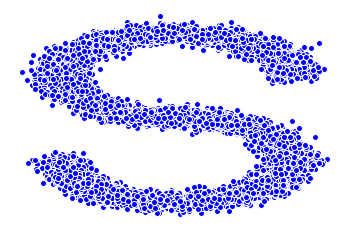

In [3]:
dataset = generate_dataset(10**4)

In [4]:
# set values for parameters

def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas


num_steps = 100

# set methods for beta
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

In [5]:
# Calculate alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt

alphas = 1-betas
alphas_prod = torch.cumprod(alphas,0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


In [6]:
# Forward process

# According to the provement, we can directly sample at any given timesteps (add noise)
# x[0] -> x[t]
def q_x(x_0,t):
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)


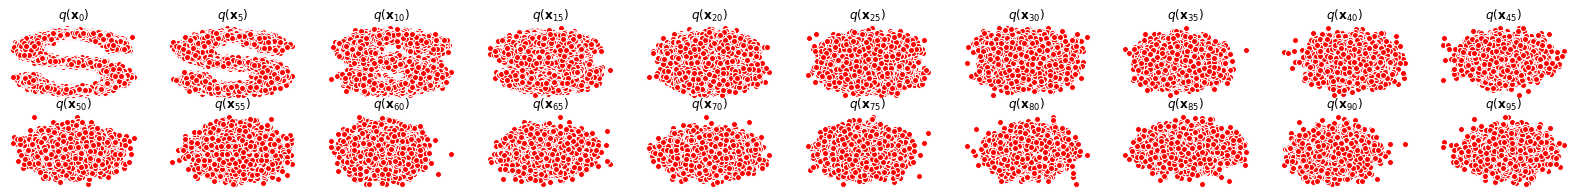

In [7]:
# show the results of forward process (when origin image add noise)
num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='black')

# total 100 steps, every 5 steps output 1 plot.
for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows])) # x[t] 
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

In [8]:
# Reverse process

class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()

        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ]
        )

    def forward(self, x, t):
        """ 生成的过程: 把t的值作为一个embedding,然后和x相加
        下边的循环等价于把每个nn.Embedding分别插入到每个nn.Linear之前
        """
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2 * idx](x)
            x += t_embedding
            x = self.linears[2 * idx + 1](x)

        x = self.linears[-1](x)

        return x

In [9]:
# Inference
def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    """from x[T] sampling"""
    t = torch.tensor([t])

    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]

    eps_theta = model(x, t)

    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()

    sample = mean + sigma_t * z

    return (sample)

def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    """from x[T] to x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

In [10]:
# loss function
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]

    # 对一个batchsize样本生成随机的时刻t
    t = torch.randint(0, n_steps, size=(batch_size // 2,))
    t = torch.cat([t, n_steps - 1 - t], dim=0)
    t = t.unsqueeze(-1)

    # x0的系数
    a = alphas_bar_sqrt[t]

    # eps的系数
    aml = one_minus_alphas_bar_sqrt[t]

    # 生成随机噪音eps
    e = torch.randn_like(x_0)

    # 构造模型的输入
    x = x_0 * a + e * aml

    # 送入模型，得到t时刻的随机噪声预测值
    output = model(x, t.squeeze(-1))

    # 与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

Training model...


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.5051


  5%|▍         | 199/4000 [00:17<05:09, 12.29it/s]

Epoch: 200, Loss: 0.3849


 10%|▉         | 399/4000 [00:36<05:38, 10.62it/s]

Epoch: 400, Loss: 0.4513


 15%|█▍        | 599/4000 [00:54<05:00, 11.30it/s]

Epoch: 600, Loss: 0.3567


 20%|██        | 800/4000 [01:13<04:52, 10.92it/s]

Epoch: 800, Loss: 0.1990


 25%|██▌       | 1000/4000 [01:31<04:19, 11.56it/s]

Epoch: 1000, Loss: 0.2517


 30%|██▉       | 1199/4000 [01:49<04:03, 11.50it/s]

Epoch: 1200, Loss: 0.2964


 35%|███▌      | 1400/4000 [02:09<04:00, 10.80it/s]

Epoch: 1400, Loss: 0.3405


 40%|███▉      | 1599/4000 [02:27<03:27, 11.55it/s]

Epoch: 1600, Loss: 0.2681


 45%|████▍     | 1799/4000 [02:45<03:17, 11.17it/s]

Epoch: 1800, Loss: 0.2361


 50%|████▉     | 1999/4000 [03:03<02:54, 11.44it/s]

Epoch: 2000, Loss: 0.4130


 55%|█████▍    | 2199/4000 [03:21<02:31, 11.87it/s]

Epoch: 2200, Loss: 0.3414


 60%|█████▉    | 2399/4000 [03:39<02:41,  9.89it/s]

Epoch: 2400, Loss: 0.2417


 65%|██████▌   | 2600/4000 [04:04<02:13, 10.46it/s]

Epoch: 2600, Loss: 0.3764


 70%|███████   | 2800/4000 [04:25<01:37, 12.28it/s]

Epoch: 2800, Loss: 0.3334


 75%|███████▌  | 3000/4000 [04:43<01:28, 11.26it/s]

Epoch: 3000, Loss: 0.1923


 80%|████████  | 3200/4000 [05:01<01:07, 11.85it/s]

Epoch: 3200, Loss: 0.1616


 85%|████████▌ | 3400/4000 [05:20<00:59, 10.14it/s]

Epoch: 3400, Loss: 0.1926


 90%|████████▉ | 3599/4000 [05:38<00:33, 11.94it/s]

Epoch: 3600, Loss: 0.4623


 95%|█████████▍| 3799/4000 [05:57<00:17, 11.46it/s]

Epoch: 3800, Loss: 0.2838


100%|██████████| 4000/4000 [06:14<00:00, 10.68it/s]


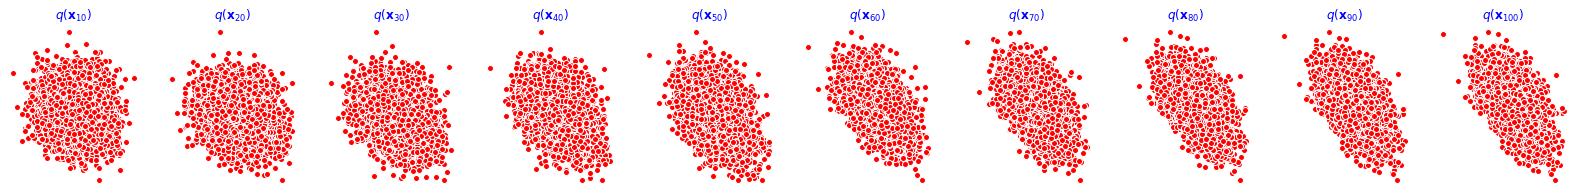

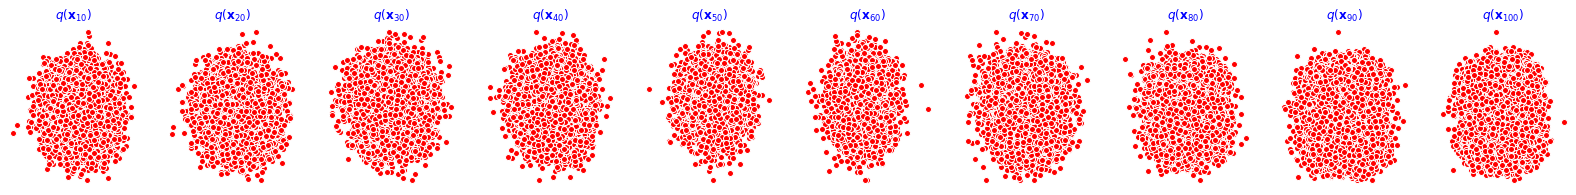

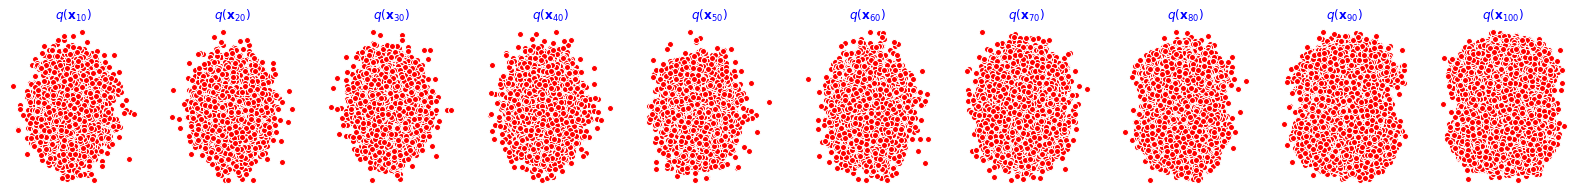

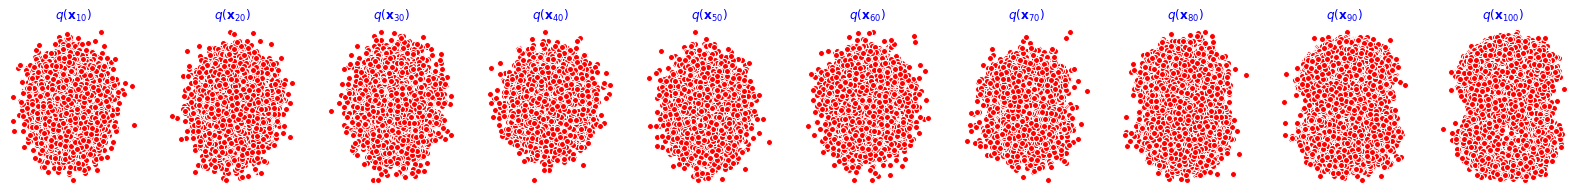

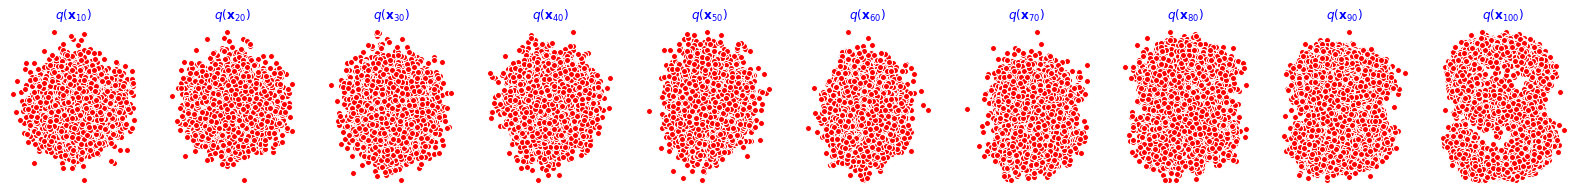

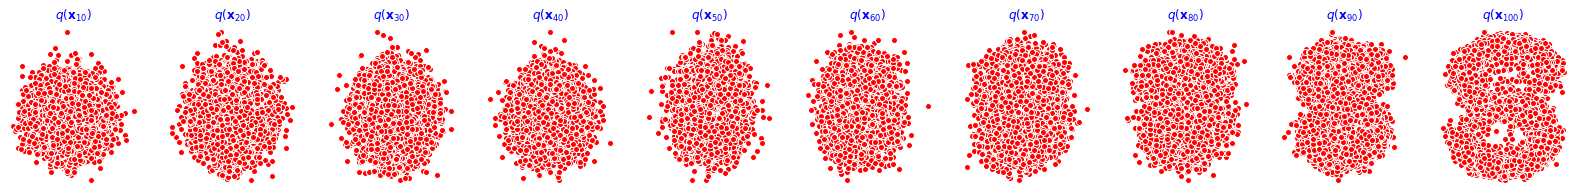

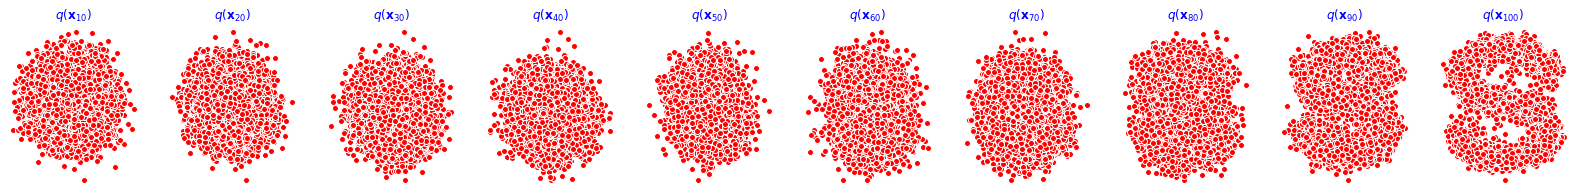

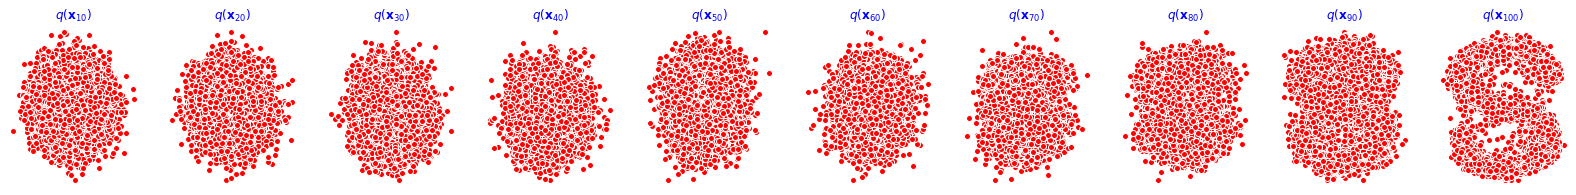

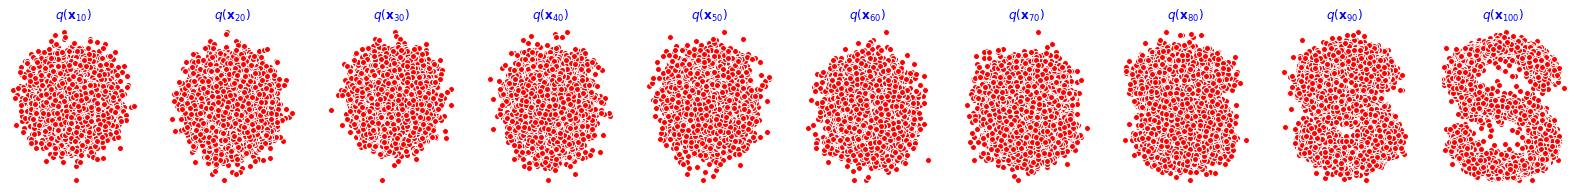

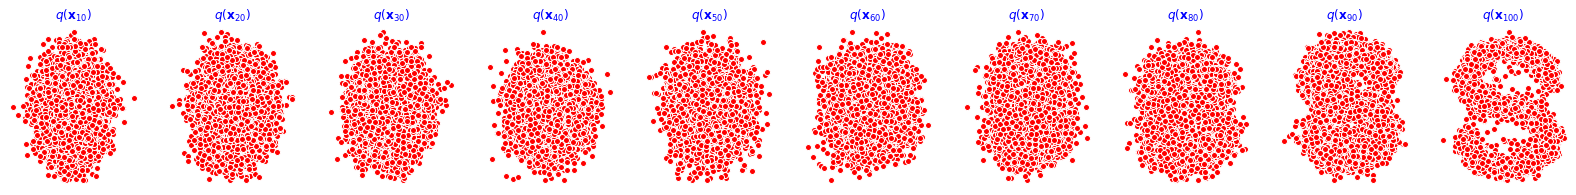

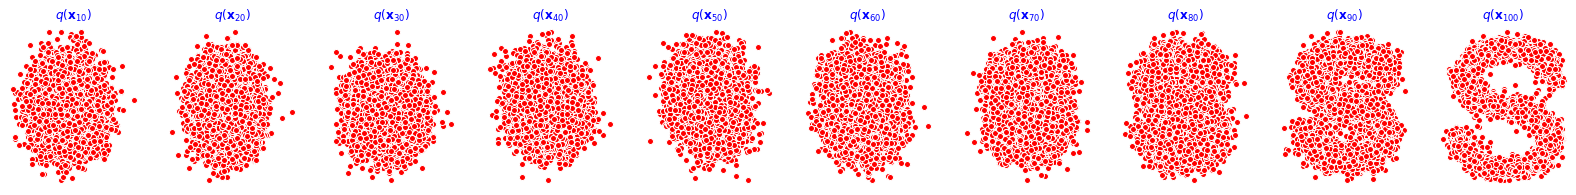

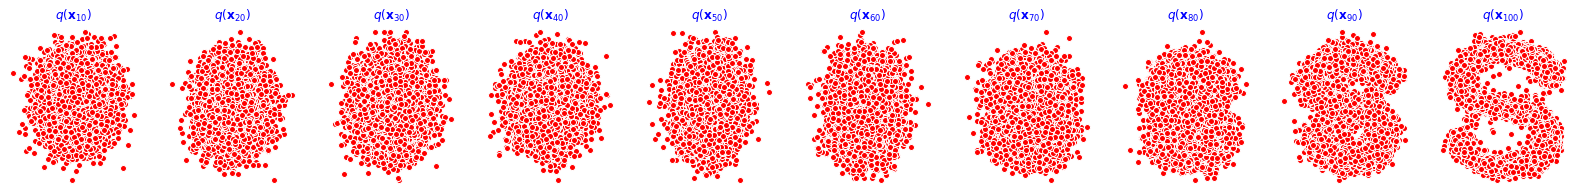

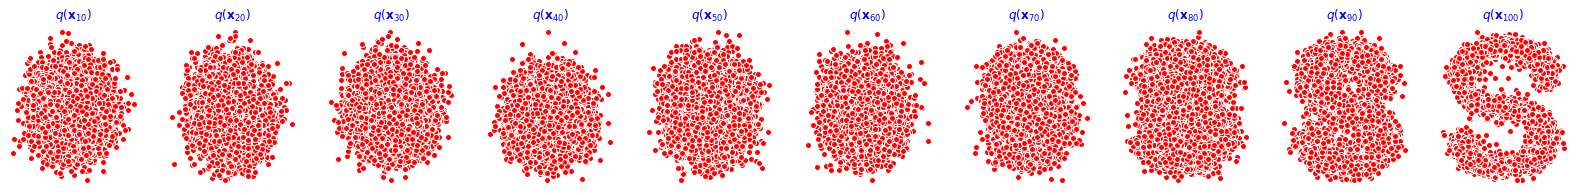

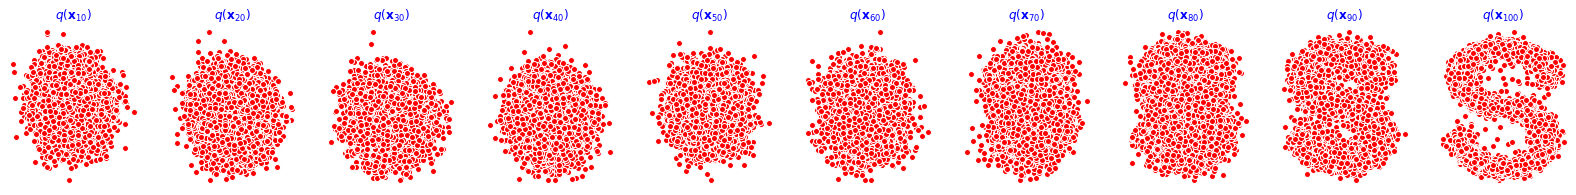

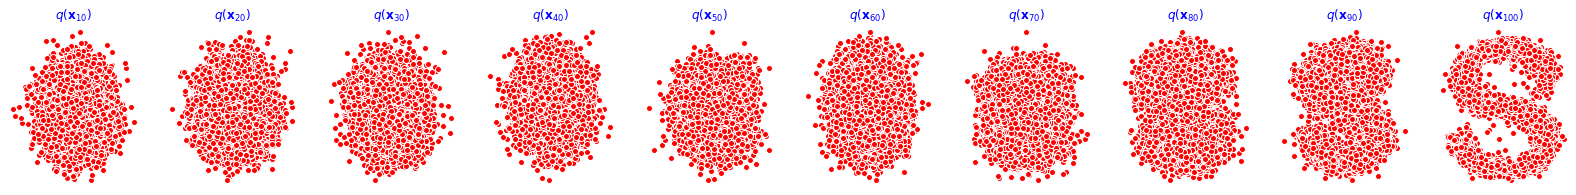

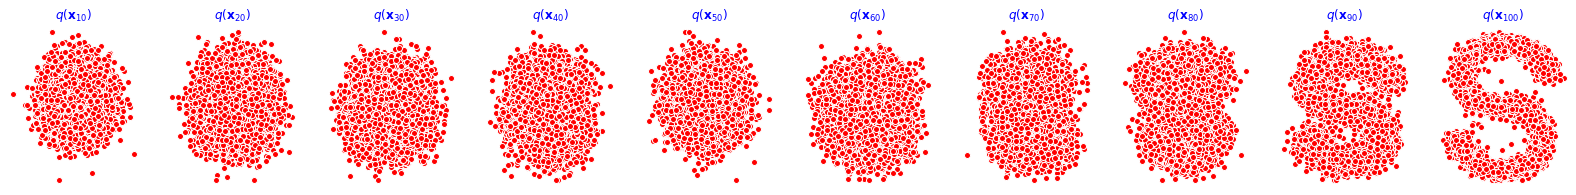

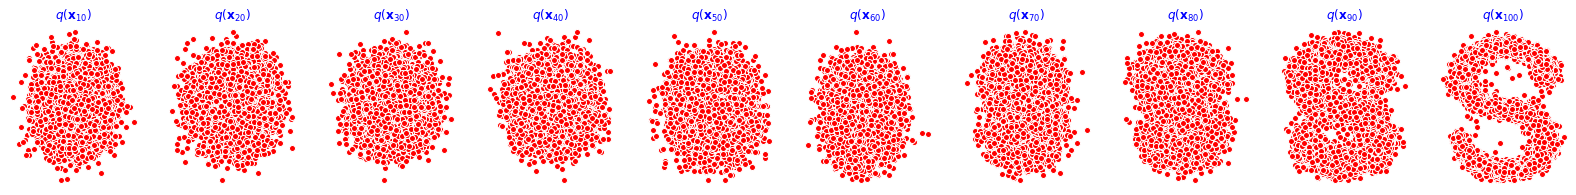

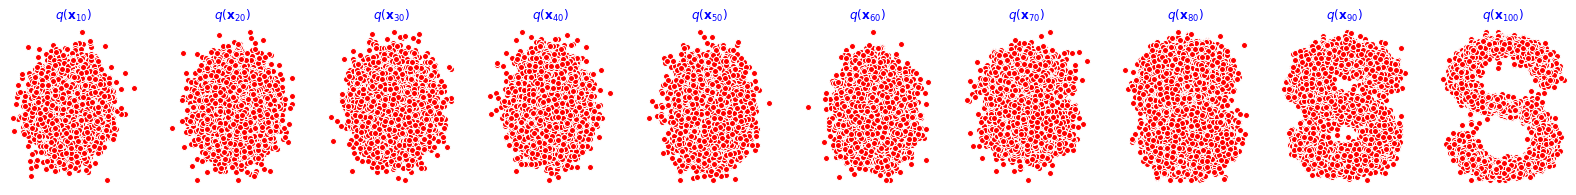

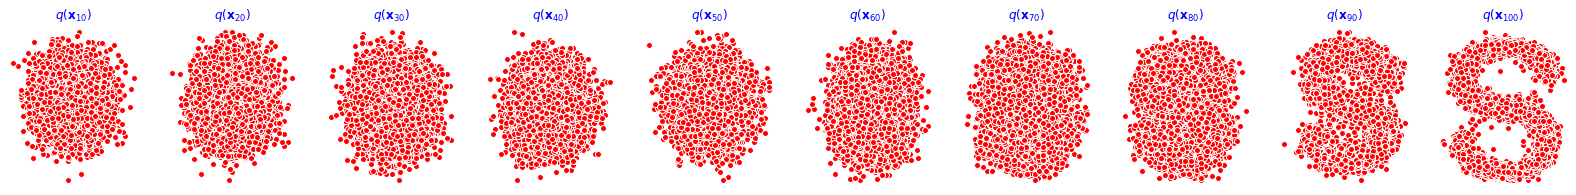

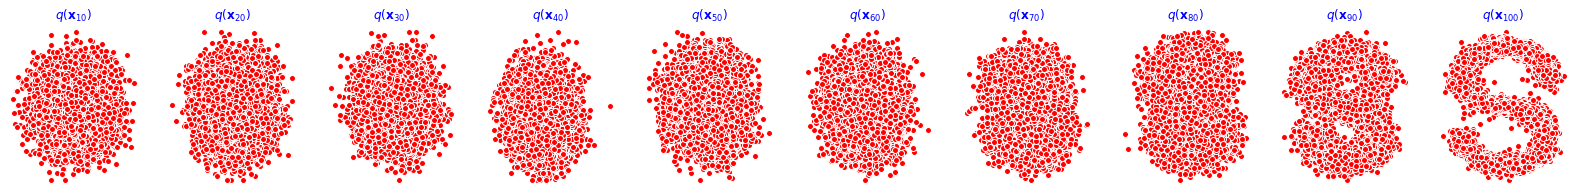

In [11]:
# Training model
seed = 1234

class EMA():
    """构建一个参数平滑器"""

    def __init__(self, mu=0.01):
        self.mu = mu
        self.shadow = {}

    def register(self, name, val):
        self.shadow[name] = val.clone()

    def __call__(self, name, x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average


print('Training model...')


batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc('text', color='blue')

model = MLPDiffusion(num_steps)  # 输出维度是2，输入是x和step
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in tqdm(range(num_epoch)):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()


    # print loss
    if (t % 200 == 0):
        tqdm.write('Epoch: {}, Loss: {:.4f}'.format(t, loss.item()))
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt) # 共100个元素

        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i - 1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white');
            axs[i - 1].set_axis_off();
            axs[i - 1].set_title('$q(\mathbf{x}_{' + str(i * 10) + '})$')

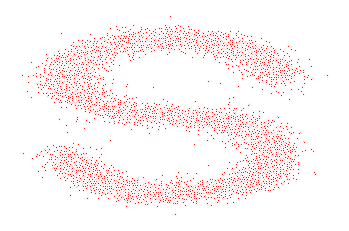

In [12]:
# Generating the forward image sequence.
imgs = []
for i in range(100):
    plt.clf()
    q_i = q_x(dataset, torch.tensor([i]))
    plt.scatter(q_i[:, 0], q_i[:, 1], color='red', edgecolor='white', s=5);
    plt.axis('off');

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='jpg')
    img = Image.open(img_buf)
    imgs.append(img)

# Generating the reserve diffusion sequense
reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach()
    plt.scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white', s=5);
    plt.axis('off')

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='jpg')
    img = Image.open(img_buf)
    reverse.append(img)

imgs = reverse

imgs[0].save("ddpm.gif",format='GIF',append_images=imgs,save_all=True,duration=100,loop=0)

This gif shows the progress of how the picture into noise, and then reserve.  
![output](output/ddpm/ddpm.gif)